This example script aims to monitor the top traded commodities of specific countries. Note: monthly data are required.

In [ ]:
# Install a pip comtradeapicall package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --upgrade comtradeapicall
# Install a pip pandas package in the current Jupyter kernel
!{sys.executable} -m pip install pandas
# Install a pip matplotlib package in the current Jupyter kernel
!{sys.executable} -m pip install matplotlib

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import comtradeapicall

In [14]:
# use .env to store the subscription key
from dotenv import load_dotenv
import os

load_dotenv()
subscription_key = os.getenv("SUBSCRIPTION_KEY")

Input parameters: reporter code in ISO, base year (to obtain the top products), flow and no of months

In [15]:
# get the latest year
from datetime import datetime
baseYear = str(datetime.now().year-1)
flow = 'X'
noOfPeriod = 15


# get availability of reporters for baseYear
df_availablereportersCA = comtradeapicall.getFinalDataAvailability(
    subscription_key=subscription_key, typeCode='C', freqCode='A', clCode='HS', reporterCode=None, period=baseYear)
df_availablereportersCM = comtradeapicall.getFinalDataAvailability(
    subscription_key=subscription_key, typeCode='C', freqCode='M', clCode='HS', reporterCode=None, period=None)

Get the available months using data availability

In [16]:
import random
df_availablereportersCA["reporterISO"] = df_availablereportersCA["reporterISO"].values.astype(
    str)
df_availablereportersCM["reporterISO"] = df_availablereportersCM["reporterISO"].values.astype(
    str)

common = set(df_availablereportersCA["reporterISO"].unique()) & \
    set(df_availablereportersCM["reporterISO"].unique())

if not common:
    raise ValueError("No common reporterISO between CA and CM.")

countryISO = random.choice(list(common))

In [17]:
df_availableperiods = comtradeapicall.getFinalDataAvailability(
    subscription_key=subscription_key, typeCode='C', freqCode='M', clCode='HS', reporterCode=comtradeapicall.convertCountryIso3ToCode(countryISO), period=None)
df_availableperiods["period"] = df_availableperiods["period"].values.astype(
    str)
targetPeriod_list = ','.join(df_availableperiods.sort_values(
    by='period', ascending=False)['period'].head(noOfPeriod).to_list())

In [18]:
# get the top 4 digits exported commodities
# classic breakdown mode will set the partner2Code to World, customsCode to Total, and motCode to Total.
df_CA_BaseYear_4Digit = comtradeapicall._getFinalData(subscription_key, typeCode='C', freqCode='A', clCode='HS', period=baseYear, reporterCode=comtradeapicall.convertCountryIso3ToCode(
    countryISO), cmdCode='AG4', flowCode=flow, partnerCode=0, partner2Code=None, customsCode=None, motCode=None, breakdownMode='classic', includeDesc=True)

Show the top traded products

In [19]:
df_CA_BaseYear_4Digit.sort_values(by='primaryValue', ascending=False)[
    ['cmdCode', 'cmdDesc', 'primaryValue']].head(5)

,cmdCode,cmdDesc,primaryValue
348,0202,Meat of bovine animals; frozen,1.538026e+09
273,1201,"Soya beans, whether or not broken",1.205824e+09
448,4403,"Wood in the rough, whether or not stripped of ...",9.827618e+08
240,0402,Milk and cream; concentrated or containing add...,5.974126e+08
376,1006,Rice,5.571942e+08


Obtaining the monthly top trade products using monthly

In [20]:
listofcmd = ','.join(df_CA_BaseYear_4Digit.sort_values(
    by='primaryValue', ascending=False)['cmdCode'].head(5).to_list())

In [21]:
df_CM_top5 = comtradeapicall._getFinalData(subscription_key, typeCode='C', freqCode='M', clCode='HS', period=targetPeriod_list, reporterCode=comtradeapicall.convertCountryIso3ToCode(countryISO), cmdCode=listofcmd, flowCode=flow, partnerCode=0, partner2Code=None, customsCode=None, motCode=None,
                                           breakdownMode='classic', includeDesc=True)

Show the changes in top trade products (monthly)

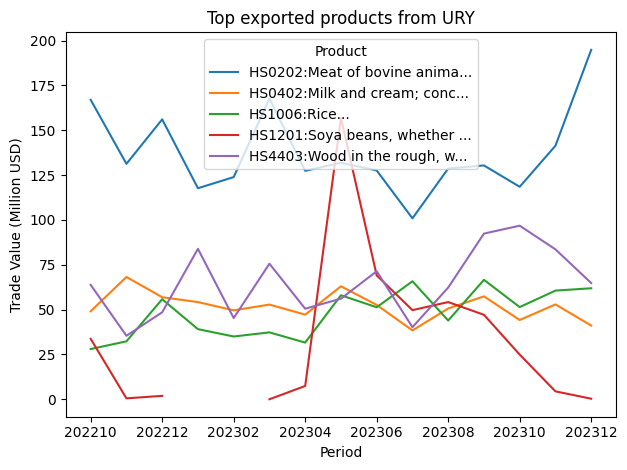

In [23]:
df_top5 = df_CM_top5.copy()
df_top5['primaryValue'] = (pd.to_numeric(
    df_top5['primaryValue'], errors='coerce') / 1e6).round(1)
df_top5['Product'] = 'HS' + df_top5['cmdCode'] + \
    ':' + df_top5['cmdDesc'].str[0:20] + '...'
df_top5.set_index(['period'], inplace=True)
df_top5.set_index('Product', append=True).unstack()['primaryValue'].plot()

# add some useful labels
plt.title('Top exported products from ' + countryISO)
plt.ylabel('Trade Value (Million USD)')
plt.xlabel('Period')
plt.tight_layout()